In [ ]:
# First part of the project, where each of the five new features created

import os
import pandas as pd
from pymol import cmd
from Bio.PDB import PDBParser, ShrakeRupley
from chempy import cpv
import numpy as np
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.structure.bonds as bonds

# Loading the dataset
file_path = '/Users/sudeboler/Desktop/AF_prediction_randomized_DMI_results.xlsx'
dataset = pd.read_excel(file_path)

# Paths to the folders containing structure files
base_path = '/Users/sudeboler/Desktop/structure_folders'
structure_folders = ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3']

results = []

# Hydrophobic residues including Glycine (GLY) and Proline (PRO)
hydrophobic_residues = {'ALA', 'VAL', 'LEU', 'ILE', 'MET', 'PHE', 'PRO', 'TRP', 'GLY'}

# Function to calculate buried area using Shrake-Rupley
def calculate_buried_area_pymol(file_path, chains):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", file_path)

    # Calculate SASA for the whole structure
    sasa = ShrakeRupley()
    sasa.compute(structure, level="A")
    total_area = sum(atom.sasa for atom in structure.get_atoms())

    # Calculate buried area for each chain separately
    chain1 = structure[0][chains[0]]
    chain2 = structure[0][chains[1]]
    
    sasa.compute(chain1, level="A")
    area_ch1 = sum(atom.sasa for atom in chain1.get_atoms())
    
    sasa.compute(chain2, level="A")
    area_ch2 = sum(atom.sasa for atom in chain2.get_atoms())

    # Calculate buried area
    buried_area = (area_ch1 + area_ch2 - total_area)
    return round(buried_area, 3)
 
# Function to calculate the minimum distance of interface residues
def minimum_interface_distance(name, chains, cutoff=5.0):
    min_distance = float('inf')  # Initialize with a large number
    
    # Select interface residues within cutoff distance from each other
    cmd.select('interface1', f'br. {name} and chain {chains[0]} within {cutoff} of {name} and chain {chains[1]}')
    cmd.select('interface2', f'br. {name} and chain {chains[1]} within {cutoff} of {name} and chain {chains[0]}')

    # Get atom information from the selections
    interface1_atoms = cmd.get_model('interface1').atom
    interface2_atoms = cmd.get_model('interface2').atom
    
    # Calculate the minimum distance between Cα atoms only
    for atom1 in interface1_atoms:
        if atom1.name == 'CA':  # Only consider Cα atoms
            for atom2 in interface2_atoms:
                if atom2.name == 'CA':  # Only consider Cα atoms
                    distance = cpv.distance(atom1.coord, atom2.coord)
                    if distance < min_distance:
                        min_distance = distance
    
    # If no distances were found, return 0, otherwise return the minimum distance
    return min_distance if min_distance != float('inf') else 0

# Function to calculate hydrogen bonds using Biotite's Baker-Hubbard algorithm
def find_h_bonds_biotite(file_path, chains):
    # Load structure using Biotite
    pdb_file = pdb.PDBFile.read(file_path)
    atom_array_stack = pdb.get_structure(pdb_file)
    
    # If the structure contains only a single model, convert AtomArrayStack to AtomArray
    if atom_array_stack.stack_depth() == 1:
        atom_array = atom_array_stack[0]
    else:
        raise ValueError("The provided structure contains multiple models. Please provide a structure with a single model.")
    
    # Generate a BondList using a distance-based approach
    bond_list = bonds.connect_via_distances(atom_array)

    # Assign the generated BondList to the atom array
    atom_array.bonds = bond_list

    # Create selection masks for the two chains
    selection1 = atom_array.chain_id == chains[0]
    selection2 = atom_array.chain_id == chains[1]
    
    # Calculate hydrogen bonds between the two chains
    try:
        triplets = struc.hbond(atom_array, selection1=selection1, selection2=selection2)
        if isinstance(triplets, tuple):
            triplets = triplets[0]  # Extract the first item if it's a tuple
    except Exception as e:
        print(f"Error calculating hydrogen bonds: {e}")
        return 0

    return len(triplets)

# Function to calculate salt bridges using BioPython
def find_salt_bridges_biopython(file_path, chains, cutoff=4.0):
    acidic_residues = {'ASP': ['OD1', 'OD2'], 'GLU': ['OE1', 'OE2']}
    basic_residues = {'ARG': ['NH1', 'NH2', 'NE'], 'LYS': ['NZ']}

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', file_path)

    chain1 = structure[0][chains[0]]
    chain2 = structure[0][chains[1]]

    salt_bridges = 0

    for res1 in chain1:
        if res1.resname in acidic_residues:
            for atom_name1 in acidic_residues[res1.resname]:
                if atom_name1 in res1:
                    atom1 = res1[atom_name1]
                    for res2 in chain2:
                        if res2.resname in basic_residues:
                            for atom_name2 in basic_residues[res2.resname]:
                                if atom_name2 in res2:
                                    atom2 = res2[atom_name2]
                                    distance = atom1 - atom2
                                    if distance <= cutoff:
                                        salt_bridges += 1

    return salt_bridges

# Function to calculate hydrophobic interactions considering only carbon atoms
def find_hydrophobic_interactions(file_path, chains, cutoff=5.0):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', file_path)

    # Get the chains
    chain1 = structure[0][chains[0]]
    chain2 = structure[0][chains[1]]

    hydrophobic_interactions = 0

    # Compare each hydrophobic residue in chain1 with each hydrophobic residue in chain2
    for res1 in chain1:
        if res1.resname in hydrophobic_residues:
            for atom1 in res1:
                if atom1.element == 'C':  # Only consider carbon atoms
                    for res2 in chain2:
                        if res2.resname in hydrophobic_residues:
                            for atom2 in res2:
                                if atom2.element == 'C':  # Only consider carbon atoms
                                    distance = atom1 - atom2
                                    if distance <= cutoff:
                                        hydrophobic_interactions += 1

    return hydrophobic_interactions


# Main loop to process all structure files
for folder in structure_folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder_path}")
        for prediction_name in os.listdir(folder_path):
            prediction_path = os.path.join(folder_path, prediction_name)
            if os.path.isdir(prediction_path):
                print(f"Processing prediction: {prediction_name}")
                for pdb_file in os.listdir(prediction_path):
                    if pdb_file.endswith('.pdb'):
                        file_path = os.path.join(prediction_path, pdb_file)
                        name = os.path.splitext(pdb_file)[0]

                        # Load the structure file using PyMOL API
                        cmd.load(file_path, name)
                        chains = cmd.get_chains(name)

                        if len(chains) == 2:
                            print(f"Processing {name} with chains {chains}")
                            hbonds = find_h_bonds_biotite(file_path, chains)
                            salt_bridges = find_salt_bridges_biopython(file_path, chains)
                            buried_area = calculate_buried_area_pymol(file_path, chains)
                            min_distance = minimum_interface_distance(name, chains)
                            hydrophobic_interactions = find_hydrophobic_interactions(file_path, chains)

                            results.append({
                                'prediction_name': prediction_name,
                                'structure_file': pdb_file,
                                'hbonds': hbonds,
                                'salt_bridges': salt_bridges,
                                'buried_area': buried_area,
                                'min_distance': min_distance,
                                'hydrophobic_interactions': hydrophobic_interactions
                            })
                    
                        else:
                            print(f"Skipping {name} because it does not have exactly 2 chains.")

                        # Clear the current structure from PyMOL to avoid memory issues
                        cmd.delete(name)


results_df = pd.DataFrame(results)
output_file_path = '/Users/sudeboler/Desktop/structure_analysis_results_biopython_with_hydrophobic_and_final.csv'  
results_df.to_csv(output_file_path, index=False)

print("Analysis complete. Results saved to:", output_file_path)



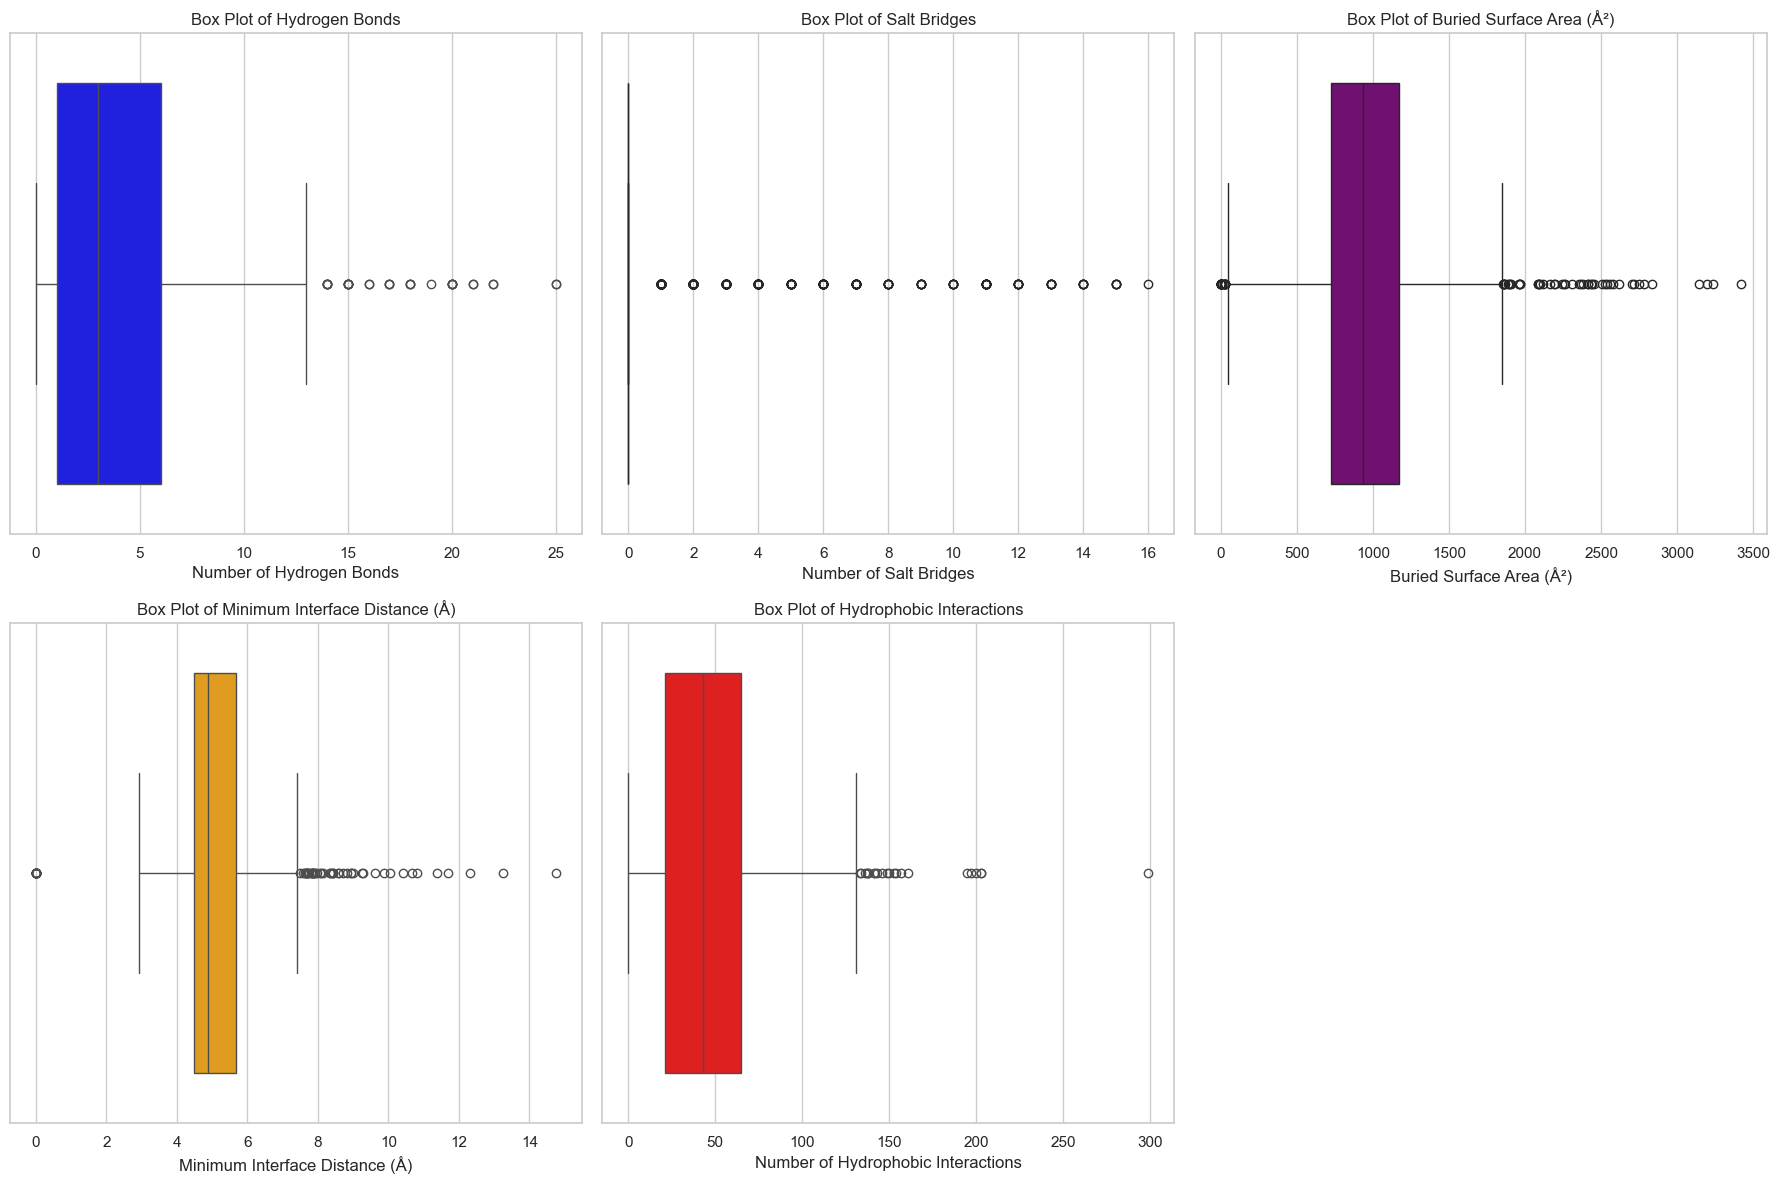

In [5]:
# Boxplot to interpret the Features

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '/Users/sudeboler/Desktop/structure_analysis_results_biopython_with_hydrophobic_and_final.csv'
results_df = pd.read_csv(file_path)

# Setting up the general appearance of plots
sns.set(style="whitegrid")

# Checking for Salt Bridges data
if results_df['salt_bridges'].sum() == 0:
    print("No significant salt bridges found in the data.")
else:
    # Boxplots of each feature for comparison
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # Adjust the layout to 2x3

    # Plot for Hydrogen Bonds
    sns.boxplot(data=results_df, x='hbonds', ax=axs[0, 0], color='blue')
    axs[0, 0].set_title('Box Plot of Hydrogen Bonds')
    axs[0, 0].set_xlabel('Number of Hydrogen Bonds')

    # Plot for Salt Bridges with a check
    if results_df['salt_bridges'].sum() > 0:
        sns.boxplot(data=results_df, x='salt_bridges', ax=axs[0, 1], color='green')
    else:
        sns.stripplot(data=results_df, x='salt_bridges', ax=axs[0, 1], color='green', jitter=True)
    axs[0, 1].set_title('Box Plot of Salt Bridges')
    axs[0, 1].set_xlabel('Number of Salt Bridges')

    # Plot for Buried Surface Area
    sns.boxplot(data=results_df, x='buried_area', ax=axs[0, 2], color='purple')
    axs[0, 2].set_title('Box Plot of Buried Surface Area (Å²)')
    axs[0, 2].set_xlabel('Buried Surface Area (Å²)')

    # Plot for Minimum Interface Distance
    sns.boxplot(data=results_df, x='min_distance', ax=axs[1, 0], color='orange')
    axs[1, 0].set_title('Box Plot of Minimum Interface Distance (Å)')
    axs[1, 0].set_xlabel('Minimum Interface Distance (Å)')

    # Plot for Hydrophobic Interactions
    sns.boxplot(data=results_df, x='hydrophobic_interactions', ax=axs[1, 1], color='red')
    axs[1, 1].set_title('Box Plot of Hydrophobic Interactions')
    axs[1, 1].set_xlabel('Number of Hydrophobic Interactions')

    # Removing the extra plot (axs[1, 2])
    fig.delaxes(axs[1, 2])  # Remove the extra subplot

    plt.tight_layout()
    plt.show()


In [2]:
# Comparison for solved structures with new features

# Distribution comparison with solved structures - Part 1 - Creation of the dataset

import os
import pandas as pd
from pymol import cmd
from Bio.PDB import PDBParser, ShrakeRupley
from chempy import cpv
import numpy as np
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.structure.bonds as bonds

# Defining the path to the folder containing the solved structures
base_path = '/Users/sudeboler/Desktop/DMI_solved_structures'

# Creating a new dataframe for storing the results
solved_structure_results = []

# Function to calculate buried area using Shrake-Rupley
def calculate_buried_area_pymol(file_path, chains):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", file_path)

    sasa = ShrakeRupley()
    sasa.compute(structure, level="A")
    total_area = sum(atom.sasa for atom in structure.get_atoms())

    chain1 = structure[0][chains[0]]
    chain2 = structure[0][chains[1]]

    sasa.compute(chain1, level="A")
    area_ch1 = sum(atom.sasa for atom in chain1.get_atoms())

    sasa.compute(chain2, level="A")
    area_ch2 = sum(atom.sasa for atom in chain2.get_atoms())

    buried_area = (area_ch1 + area_ch2 - total_area)
    return round(buried_area, 3)

# Function to calculate the minimum distance of interface residues
def minimum_interface_distance(name, chains, cutoff=5.0):
    min_distance = float('inf')
    
    cmd.select('interface1', f'br. {name} and chain {chains[0]} within {cutoff} of {name} and chain {chains[1]}')
    cmd.select('interface2', f'br. {name} and chain {chains[1]} within {cutoff} of {name} and chain {chains[0]}')

    interface1_atoms = cmd.get_model('interface1').atom
    interface2_atoms = cmd.get_model('interface2').atom
    
    for atom1 in interface1_atoms:
        if atom1.name == 'CA':
            for atom2 in interface2_atoms:
                if atom2.name == 'CA':
                    distance = cpv.distance(atom1.coord, atom2.coord)
                    if distance < min_distance:
                        min_distance = distance
    
    return min_distance if min_distance != float('inf') else 0


# Function to calculate hydrogen bonds using Biotite's Baker-Hubbard algorithm
def find_h_bonds_biotite(file_path, chains):
    pdb_file = pdb.PDBFile.read(file_path)
    atom_array_stack = pdb.get_structure(pdb_file)
    
    if atom_array_stack.stack_depth() == 1:
        atom_array = atom_array_stack[0]
    else:
        raise ValueError("The provided structure contains multiple models.")
    
    bond_list = bonds.connect_via_distances(atom_array)
    atom_array.bonds = bond_list

    selection1 = atom_array.chain_id == chains[0]
    selection2 = atom_array.chain_id == chains[1]

    try:
        triplets = struc.hbond(atom_array, selection1=selection1, selection2=selection2)
        if isinstance(triplets, tuple):
            triplets = triplets[0]
    except Exception as e:
        print(f"Error calculating hydrogen bonds: {e}")
        return 0

    return len(triplets)

# Function to calculate salt bridges using BioPython
def find_salt_bridges_biopython(file_path, chains, cutoff=4.0):
    acidic_residues = {'ASP': ['OD1', 'OD2'], 'GLU': ['OE1', 'OE2']}
    basic_residues = {'ARG': ['NH1', 'NH2', 'NE'], 'LYS': ['NZ']}

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', file_path)

    chain1 = structure[0][chains[0]]
    chain2 = structure[0][chains[1]]

    salt_bridges = 0

    for res1 in chain1:
        if res1.resname in acidic_residues:
            for atom_name1 in acidic_residues[res1.resname]:
                if atom_name1 in res1:
                    atom1 = res1[atom_name1]
                    for res2 in chain2:
                        if res2.resname in basic_residues:
                            for atom_name2 in basic_residues[res2.resname]:
                                if atom_name2 in res2:
                                    atom2 = res2[atom_name2]
                                    distance = atom1 - atom2
                                    if distance <= cutoff:
                                        salt_bridges += 1

    return salt_bridges


# Function to calculate hydrophobic interactions
def find_hydrophobic_interactions(file_path, chains, cutoff=5.0):
    hydrophobic_residues = ['ALA', 'VAL', 'LEU', 'ILE', 'MET', 'PHE', 'TRP', 'PRO', 'GLY']
    
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', file_path)

    chain1 = structure[0][chains[0]]
    chain2 = structure[0][chains[1]]

    hydrophobic_interactions = 0

    for res1 in chain1:
        if res1.resname in hydrophobic_residues:
            for atom1 in res1:
                if atom1.element == 'C':  # Only consider carbon atoms
                    for res2 in chain2:
                        if res2.resname in hydrophobic_residues:
                            for atom2 in res2:
                                if atom2.element == 'C':  # Only consider carbon atoms
                                    distance = atom1 - atom2
                                    if distance <= cutoff:
                                        hydrophobic_interactions += 1

    return hydrophobic_interactions

# Main loop to process all solved structures
for pdb_file in os.listdir(base_path):
    if pdb_file.endswith('.pdb'):
        file_path = os.path.join(base_path, pdb_file)
        name = os.path.splitext(pdb_file)[0]

        cmd.load(file_path, name)
        chains = cmd.get_chains(name)

        if len(chains) == 2:
            print(f"Processing {name} with chains {chains}")
            hbonds = find_h_bonds_biotite(file_path, chains)
            salt_bridges = find_salt_bridges_biopython(file_path, chains)
            buried_area = calculate_buried_area_pymol(file_path, chains)
            min_distance = minimum_interface_distance(name, chains)
            hydrophobic_interactions = find_hydrophobic_interactions(file_path, chains)

            solved_structure_results.append({
                'pdb_id': pdb_file.split('_')[0],
                'structure_file': pdb_file,
                'hbonds': hbonds,
                'salt_bridges': salt_bridges,
                'buried_area': buried_area,
                'min_distance': min_distance,
                'hydrophobic_interactions': hydrophobic_interactions
            })

            cmd.delete(name)

solved_structure_df = pd.DataFrame(solved_structure_results)
output_file_path = '/Users/sudeboler/Desktop/solved_structure_analysis_results_latest.csv'
solved_structure_df.to_csv(output_file_path, index=False)

print("Analysis complete. Results saved to:", output_file_path)






Processing 2JK9_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1B8Q_min_DMI with chains ['A', 'B']
Processing 4GGD_min_DMI with chains ['A', 'B']
Processing 5F74_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1DDV_min_DMI with chains ['A', 'B']
Processing 2RR3_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1CKA_min_DMI with chains ['A', 'B']
Processing 2O8G_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4NEE_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1B72_min_DMI with chains ['A', 'B']
Processing 2D1K_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3SOQ_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1KYU_min_DMI with chains ['A', 'B']
Processing 3OGL_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4BH6_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2R03_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1EG4_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4BXU_min_DMI with chains ['A', 'B']
Processing 4F0Z_min_DMI with chains ['A', 'B']
Processing 2JKR_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2XS0_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2V3S_min_DMI with chains ['A', 'B']
Processing 2V8C_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3QIS_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3N5U_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1ATP_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1KY7_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1DPU_min_DMI with chains ['A', 'B']
Processing 1FF1_min_DMI with chains ['A', 'B']
Processing 5VZU_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 6G84_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3HQM_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1EVH_min_DMI with chains ['A', 'B']
Processing 1C9I_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 5MLW_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1YCR_min_DMI with chains ['A', 'B']
Processing 6FUZ_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2ODD_min_DMI with chains ['A', 'B']
Processing 4FMO_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2CE8_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4H3Q_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2V52_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2I3S_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1JGN_min_DMI with chains ['A', 'B']
Processing 3WP0_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1MFG_min_DMI with chains ['A', 'B']
Processing 1AXC_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2ORZ_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1CZY_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3RDV_min_DMI with chains ['A', 'B']
Processing 1F95_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2ROC_min_DMI with chains ['A', 'B']
Processing 3UXG_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1GO4_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1SXJ_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1O0P_min_DMI with chains ['A', 'B']
Processing 4CY3_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2LSI_min_DMI with chains ['A', 'B']
Processing 5AZG_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4H3B_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3MQS_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1M4P_min_DMI with chains ['A', 'B']
Processing 3GB8_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4CQO_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1H25_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2FLU_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3EU7_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2A25_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3AA1_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 5EOD_min_DMI with chains ['A', 'B']
Processing 1CA9_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2GPH_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3WN7_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2KQS_min_DMI with chains ['A', 'B']
Processing 3BQO_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3VVW_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4EOY_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1GWQ_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1N4M_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2Y48_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 5ETA_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2X04_min_DMI with chains ['A', 'B']
Processing 2IX7_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2W84_min_DMI with chains ['A', 'B']
Processing 5IGO_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2ZVL_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1GH6_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2XS1_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1NW9_min_DMI with chains ['A', 'B']
Processing 2ZNE_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2YKT_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3TEI_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2R02_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2GBQ_min_DMI with chains ['A', 'B']
Processing 3ZFW_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4J2X_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2KXH_min_DMI with chains ['A', 'B']
Processing 1D5G_min_DMI with chains ['A', 'B']
Processing 1YY6_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1PD7_min_DMI with chains ['A', 'B']
Processing 2G30_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3TWU_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2L8J_min_DMI with chains ['A', 'B']
Processing 2BZ8_min_DMI with chains ['A', 'B']
Processing 1S70_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1O6K_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1PJM_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1SYQ_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2PZO_min_DMI with chains ['A', 'B']
Processing 3UVK_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4KMD_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 7DS2_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 5HKH_min_DMI with chains ['A', 'B']
Processing 1JWG_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2ASQ_min_DMI with chains ['A', 'B']
Processing 2A41_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1L2Z_min_DMI with chains ['A', 'B']
Processing 4CY2_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2P1Q_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 5FJX_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2K42_min_DMI with chains ['A', 'B']
Processing 1O9U_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1BXX_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2MOW_min_DMI with chains ['A', 'B']
Processing 1KPS_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4YOC_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2B9J_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 4ZI2_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1MKE_min_DMI with chains ['A', 'B']
Processing 2JQ9_min_DMI with chains ['A', 'B']
Processing 1ELR_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 2C0L_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1JD5_min_DMI with chains ['A', 'B']
Processing 1UTC_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(
/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 3GM1_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1NTV_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Processing 1ZUB_min_DMI with chains ['A', 'B']
Processing 1KKQ_min_DMI with chains ['A', 'B']


/opt/anaconda3/envs/iss/lib/python3.12/site-packages/biotite/structure/hbond.py:136: UserWarning: Input structure does not contain hydrogen atoms, hence no hydrogen bonds can be identified
  warnings.warn(


Analysis complete. Results saved to: /Users/sudeboler/Desktop/solved_structure_analysis_results_latest.csv


/var/folders/tw/wmc2mpvs1wsff2l10ck_mcl00000gn/T/ipykernel_1523/3534409690.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df[combined_df['dataset_type'] != 'Unknown'],


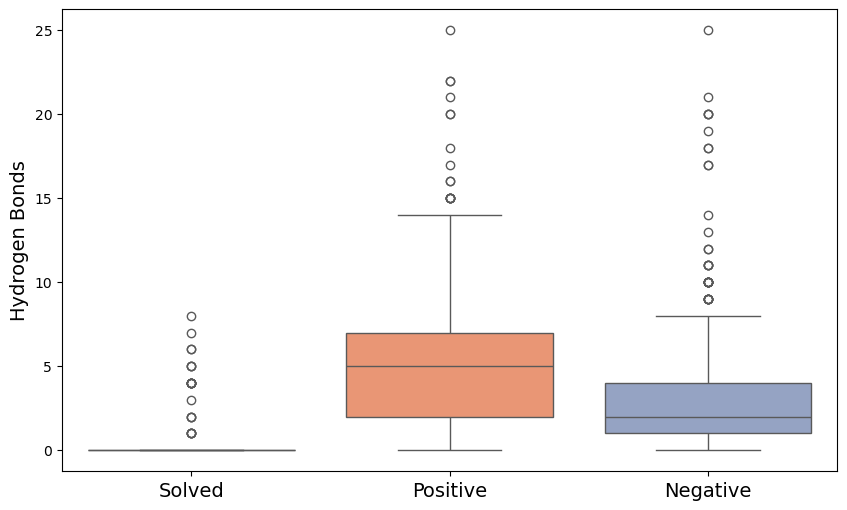

/var/folders/tw/wmc2mpvs1wsff2l10ck_mcl00000gn/T/ipykernel_1523/3534409690.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df[combined_df['dataset_type'] != 'Unknown'],


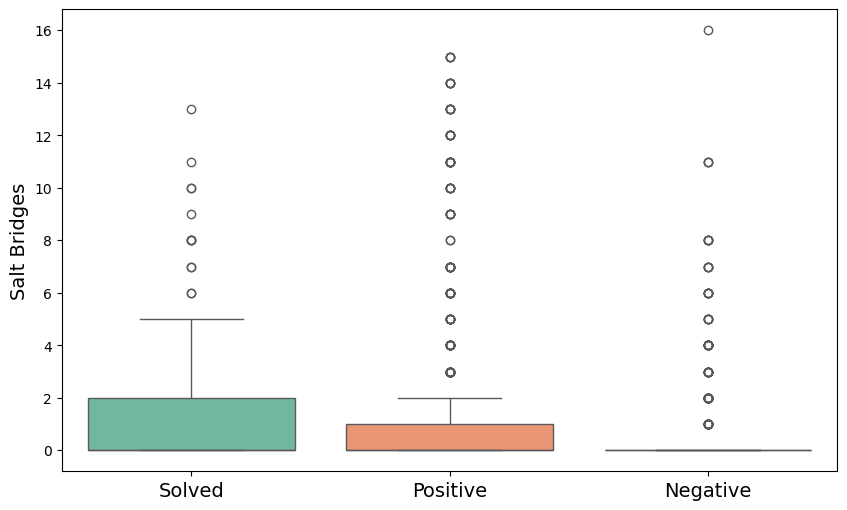

/var/folders/tw/wmc2mpvs1wsff2l10ck_mcl00000gn/T/ipykernel_1523/3534409690.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df[combined_df['dataset_type'] != 'Unknown'],


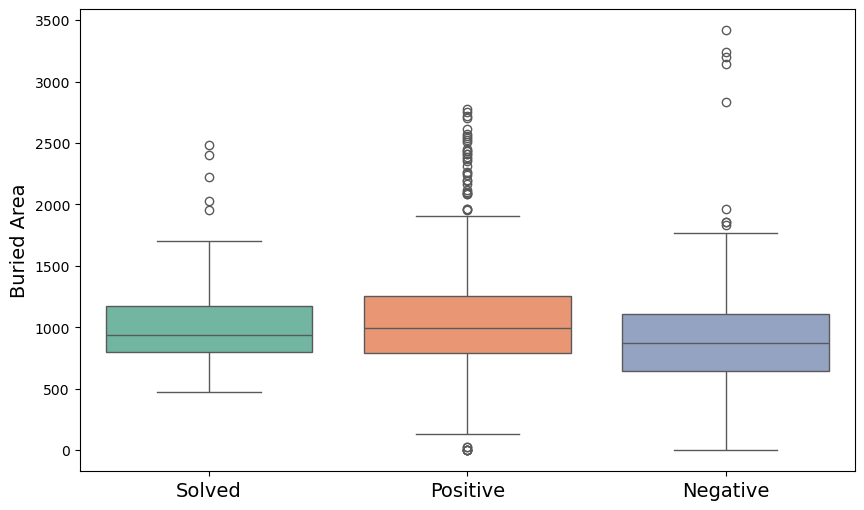

/var/folders/tw/wmc2mpvs1wsff2l10ck_mcl00000gn/T/ipykernel_1523/3534409690.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df[combined_df['dataset_type'] != 'Unknown'],


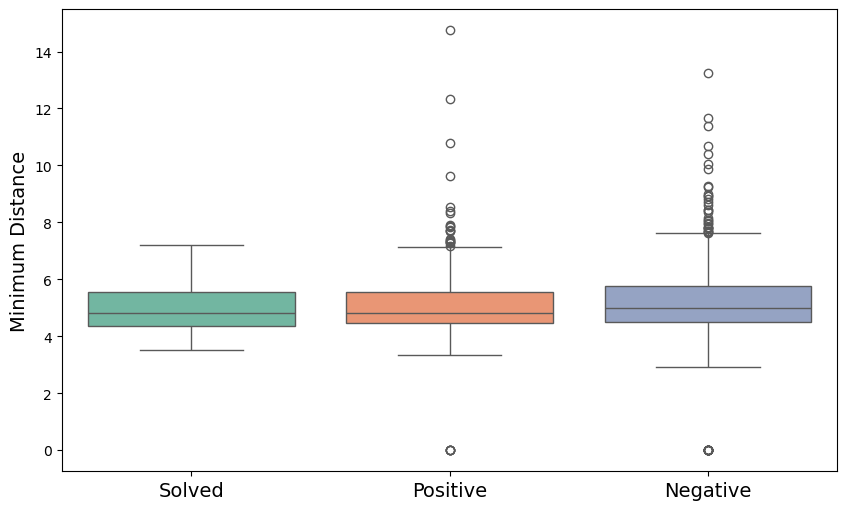

/var/folders/tw/wmc2mpvs1wsff2l10ck_mcl00000gn/T/ipykernel_1523/3534409690.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df[combined_df['dataset_type'] != 'Unknown'],


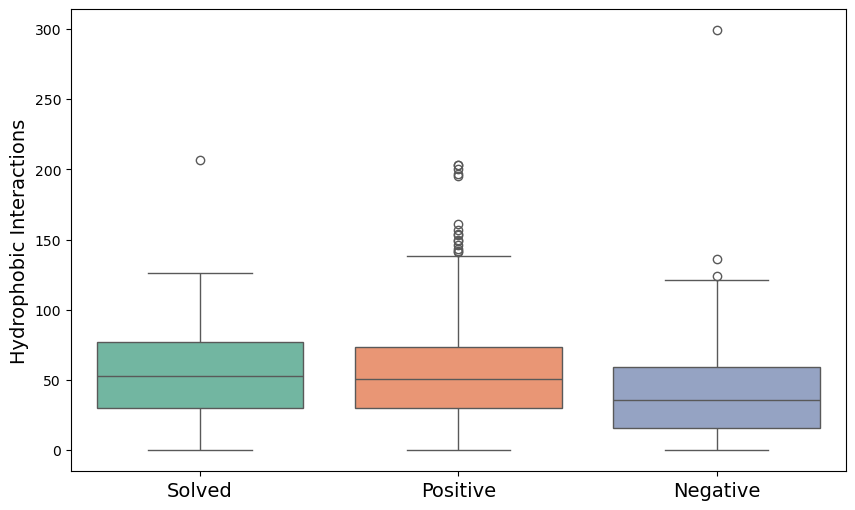

In [1]:
### Visualization for comparing Solved Structures with Positive and Negative 


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the Solved Structures and AlphaFold Predictions
solved_file_path = '/Users/sudeboler/Desktop/solved_structure_analysis_results.csv'
alphafold_file_path = '/Users/sudeboler/Desktop/structure_analysis_results_biopython_with_hydrophobic_and_final.csv'
prediction_file_path = '/Users/sudeboler/Desktop/AF_prediction_randomized_DMI_results.xlsx'

solved_df = pd.read_csv(solved_file_path)
alphafold_df = pd.read_csv(alphafold_file_path)
prediction_df = pd.read_excel(prediction_file_path)

# Filtering AlphaFold Predictions into Known Minimal and Random Minimal
known_minimal = prediction_df[prediction_df['num_mutation_in_motif'] == 'known minimal']['prediction_name'].tolist()
random_minimal = prediction_df[prediction_df['num_mutation_in_motif'] == 'random minimal']['prediction_name'].tolist()

# Labeling AlphaFold predictions based on prediction_name
alphafold_df['dataset_type'] = alphafold_df['prediction_name'].apply(
    lambda x: 'Positive' if x in known_minimal else ('Negative' if x in random_minimal else 'Unknown')
)

# Adding a column to the solved structures to identify them as "Solved"
solved_df['dataset_type'] = 'Solved'

# Combining both datasets into a single DataFrame
combined_df = pd.concat([solved_df, alphafold_df], ignore_index=True)

# List of features to plot and their updated labels
features = ['hbonds', 'salt_bridges', 'buried_area', 'min_distance', 'hydrophobic_interactions']
y_labels = {
    'hbonds': 'Hydrogen Bonds',
    'salt_bridges': 'Salt Bridges',
    'buried_area': 'Buried Area',
    'min_distance': 'Minimum Distance',
    'hydrophobic_interactions': 'Hydrophobic Interactions'
}

# Plotting boxplots for each feature with more understandable y-axis labels, Solved/Positive/Negative x-axis labels, and without titles
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_df[combined_df['dataset_type'] != 'Unknown'], 
                x='dataset_type', y=feature, palette='Set2')
    plt.xticks(ticks=[0, 1, 2], labels=['Solved', 'Positive', 'Negative'], fontsize=14)  # Keep labels but remove "Dataset Type"
    plt.ylabel(y_labels[feature], fontsize=14)
    plt.xlabel('')  # Remove "Dataset Type" from below x-axis
    plt.show()


In [ ]:
# MERGING DATASETS 


import pandas as pd


original_file_path = '/Users/sudeboler/Desktop/AF_prediction_randomized_DMI_results.xlsx'
new_features_file_path = '/Users/sudeboler/Desktop/structure_analysis_results_biopython_with_hydrophobic_and_final.csv'

original_df = pd.read_excel(original_file_path)
new_features_df = pd.read_csv(new_features_file_path)

# Filtering the original dataset for "known minimal" and "random minimal"
filtered_original_df = original_df[original_df['num_mutation_in_motif'].isin(['known minimal', 'random minimal'])]

# Normalizing the structure_file column (remove ".pdb" to match model_id)
new_features_df['model_id'] = new_features_df['structure_file'].str.replace('.pdb', '')

# Merging the datasets on prediction_name and model_id
merged_df = pd.merge(filtered_original_df, new_features_df, 
                     left_on=['prediction_name', 'model_id'], 
                     right_on=['prediction_name', 'model_id'], 
                     how='inner')

# Dropping unnecessary columns if needed (e.g., structure_file if model_id is enough)
merged_df = merged_df.drop(columns=['structure_file'])

output_file_path = '/Users/sudeboler/Desktop/final_merged_dataset.csv'
merged_df.to_csv(output_file_path, index=False)

# Previewing the merged dataset
print("Merged dataset preview:")
print(merged_df.head())

In [6]:
# NEXT STEPS

# Data Preproccessing - not necessary for this data but I did it anyway

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Loading the merged dataset
final_df = pd.read_csv('/Users/sudeboler/Desktop/final_merged_dataset.csv')

# Separating features and target variable
X = final_df.drop(columns=['prediction_name', 'label', 'num_mutation_in_motif', 'model_id'])
y = final_df['label']

# Handling any missing values by filling with the mean of each column
X.fillna(X.mean(), inplace=True)

# Scaling the features (important for some models like SVM, Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training (80%) and testing sets (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Output the shapes of the training and test sets
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (1088, 17)
Test set shape: (272, 17)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Test Accuracy: 0.875
AUC-ROC Score: 0.9365671641791045
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       134
           1       0.94      0.80      0.87       138

    accuracy                           0.88       272
   macro avg       0.88      0.88      0.87       272
weighted avg       0.88      0.88      0.87       272



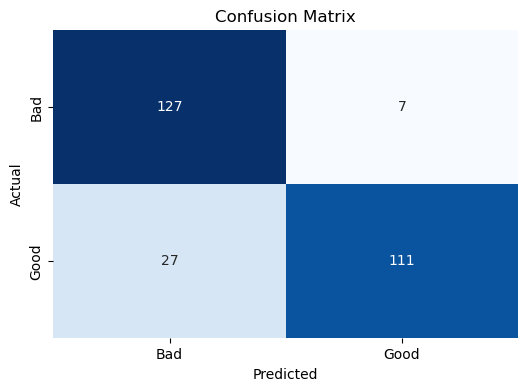

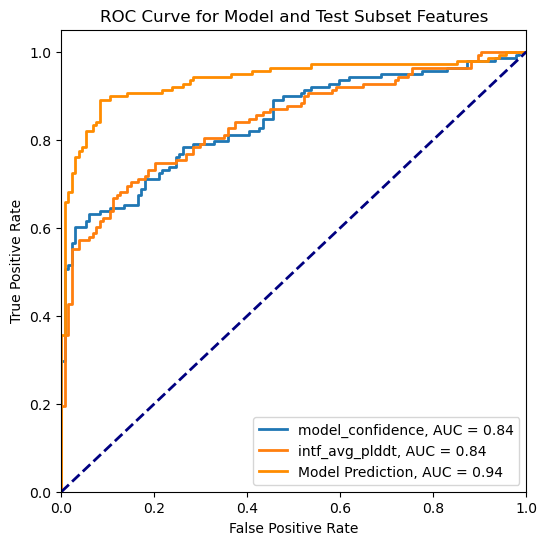

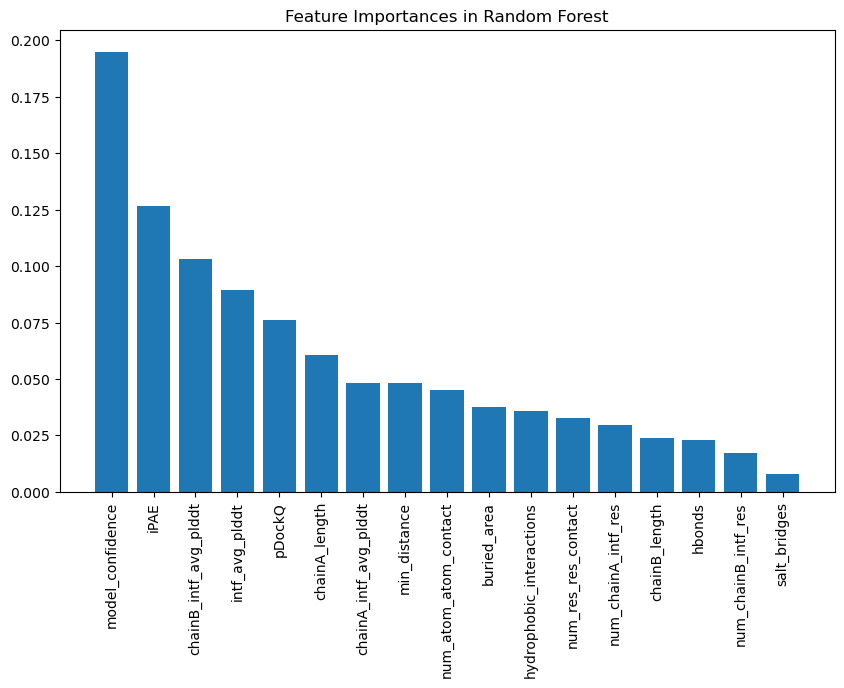

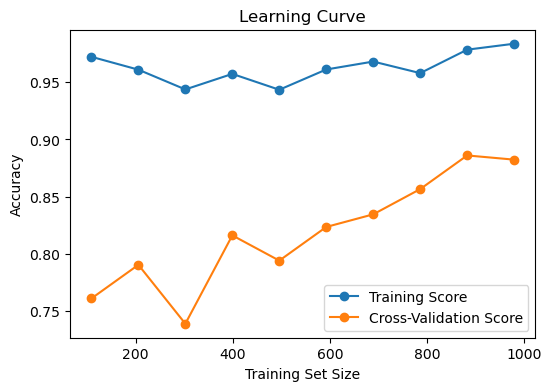

[CV] END gb__learning_rate=0.02, gb__max_depth=4, gb__min_samples_leaf=4, gb__min_samples_split=8, gb__n_estimators=100, gb__subsample=0.9, rf__max_depth=15, rf__min_samples_leaf=5, rf__min_samples_split=8, rf__n_estimators=150; total time=   0.6s
[CV] END gb__learning_rate=0.02, gb__max_depth=5, gb__min_samples_leaf=5, gb__min_samples_split=8, gb__n_estimators=100, gb__subsample=0.8, rf__max_depth=None, rf__min_samples_leaf=5, rf__min_samples_split=6, rf__n_estimators=250; total time=   0.8s
[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_samples_leaf=4, gb__min_samples_split=8, gb__n_estimators=150, gb__subsample=0.9, rf__max_depth=20, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time=   0.9s
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__min_samples_leaf=5, gb__min_samples_split=6, gb__n_estimators=150, gb__subsample=0.8, rf__max_depth=20, rf__min_samples_leaf=5, rf__min_samples_split=6, rf__n_estimators=250; total time=   0.8s
[CV] 

In [2]:
# Machine Learning Part and Results


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn import metrics


final_df = pd.read_csv('/Users/sudeboler/Desktop/final_merged_dataset.csv')

# Separating features (X) and target (y)
X = final_df.drop(columns=['label', 'prediction_name', 'num_mutation_in_motif', 'model_id'])
y = final_df['label']

# Data Augmentation with SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split on resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initializing the models with early stopping for Gradient Boosting
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42, n_iter_no_change=5, validation_fraction=0.1)

# Combining the models using a Voting Classifier (Blending)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model), 
    ('gb', gb_model)
], voting='soft')

# Defining new parameter grid for tuning the voting classifier
param_grid = {
    'rf__n_estimators': [150, 200, 250],         # Slightly increase n_estimators for Random Forest
    'rf__max_depth': [15, 20, None],             # Relax max_depth slightly
    'rf__min_samples_split': [6, 8, 10],         # Maintain higher min_samples_split for better generalization
    'rf__min_samples_leaf': [4, 5],              # Keep min_samples_leaf higher, but relax a bit

    'gb__n_estimators': [100, 150],              # Slightly fewer boosting iterations for GB to avoid overfitting
    'gb__learning_rate': [0.01, 0.02, 0.05],     # Fine-tune smaller learning rate for smoother updates
    'gb__max_depth': [3, 4, 5],                  # Keep the max depth smaller
    'gb__min_samples_split': [6, 8],             # Allow larger samples for splitting to generalize better
    'gb__min_samples_leaf': [4, 5],              # Keep larger leaves for GB
    'gb__subsample': [0.8, 0.9]                  # Subsample for Gradient Boosting to prevent overfitting
}

# Stratified K-Fold for better validation
stratified_kfold = StratifiedKFold(n_splits=10)

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=voting_clf, param_distributions=param_grid, cv=stratified_kfold,
                                   n_iter=20, scoring='accuracy', n_jobs=-1, verbose=2)

# Fitting the model
random_search.fit(X_train, y_train)

# Evaluating the model on the test set
y_pred = random_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:, 1])

print(f"Test Accuracy: {accuracy}")
print(f"AUC-ROC Score: {roc_auc}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualization 

# Confusion Matrix with "Bad" and "Good" labels
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve with additional test subset features and machine learning results
fig, ax = plt.subplots(figsize=(6, 6))

# Computing ROC for model confidence
fpr, tpr, _ = roc_curve(y_test, X_test['model_confidence'])
roc_auc_value = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, label=f'model_confidence, AUC = {roc_auc_value:.2f}')

# Computing ROC for intf_avg_plddt
fpr, tpr, _ = roc_curve(y_test, X_test['intf_avg_plddt'])
roc_auc_value = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, label=f'intf_avg_plddt, AUC = {roc_auc_value:.2f}')

# Computing ROC for the model's prediction probabilities (Voting Classifier results)
y_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_value = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, label=f'Model Prediction, AUC = {roc_auc_value:.2f}', color='darkorange')

# Configuring the plot
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Model and Test Subset Features')
ax.legend(loc="lower right")
plt.show()


# Configuring the plot
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Model and Test Subset Features')
ax.legend(loc="lower right")
plt.show()



# Feature Importance (for Random Forest model in Voting Classifier)
rf_best = random_search.best_estimator_.named_estimators_['rf']
importances_rf = rf_best.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices_rf], rotation=90)
plt.show()

# Learning Curve
train_sizes = np.linspace(0.1, 0.9, 10)  # This gives proportions from 0.1 to 0.9 (as 1.0 can lead to errors)
train_scores = []
cv_scores = []
for size in train_sizes:
    # Split the training data according to the proportion size
    X_train_size, _, y_train_size, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)
    
    # Fit the best estimator model found in RandomizedSearchCV
    random_search.best_estimator_.fit(X_train_size, y_train_size)
    
    # Calculate training accuracy and validation accuracy
    train_scores.append(random_search.best_estimator_.score(X_train_size, y_train_size))
    cv_scores.append(random_search.best_estimator_.score(X_test, y_test))

# Plotting the learning curve
plt.figure(figsize=(6, 4))
plt.plot(train_sizes * len(X_train), train_scores, label='Training Score', marker='o')
plt.plot(train_sizes * len(X_train), cv_scores, label='Cross-Validation Score', marker='o')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


